In [8]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import scipy.ndimage
import os

In [13]:
# Define the WNVParameters class
class WNVParameters:
    def __init__(self):
        self.transovarial_rate = 0.05  # Probability of vertical transmission in mosquitoes
        self.mosquito_life_span = 15  # Average lifespan of mosquitoes in days
        self.bird_life_span = 365  # Average lifespan of birds in days
        self.initial_mosquito_count = 40716
        self.initial_bird_count = 15296
        self.initial_infectious_fraction = 0.1
        self.recovery_rate = 0.05  # Probability of recovery for infected birds
        self.grid_width = 921
        self.grid_height = 393
        self.startDOY = 1
        self.simulation_steps = 360

    def mosquito_abundance_probability(self, T):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        sigma = 5
        if T >= optimal_temp :
            sigma = 9  # Controls the width of the peak around the optimal temperature
        temp_factor = np.exp(-0.5 * ((T - optimal_temp) / sigma) ** 2)  # Gaussian function for temperature
        temp_factor = np.clip(temp_factor, 0, 1)  # Ensuring values are between 0 and 1
        return temp_factor * (1 - (T - 25) / 26)  # Gradually decrease after 26

    ##################################################

    def mosquito_birth_rate(self, T, H):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        lower_temp_limit = 15  # Updated lower temperature threshold for breeding
        upper_temp_limit = 35  # Updated upper temperature threshold for breeding
        optimal_humidity = 70  # Optimal humidity for mosquito breeding
        lower_humidity_limit = 0  # Updated lower humidity threshold for breeding
        upper_humidity_limit = 90  # Updated upper humidity threshold for breeding

        # Temperature factor based on Gaussian-like distribution around the optimal temperature
        temp_factor = np.where(T < lower_temp_limit,
                            0.2,  # Lower birth rate with very low temperature
                            np.where(T <= upper_temp_limit,
                                        np.exp(-0.02 * (T - optimal_temp) ** 2),  # Near-optimal birth rate at optimal temperature
                                        0.2))  # Lower birth rate with very high temperature
        
        # Humidity factor based on Gaussian-like distribution around the optimal humidity
        humidity_factor = np.where(H < lower_humidity_limit,
                                0.3,  # Lower birth rate with very low humidity
                                np.where(H <= upper_humidity_limit,
                                            np.exp(-0.001 * (H - optimal_humidity) ** 2),  # Near-optimal birth rate at optimal humidity
                                            0.2))  # Lower birth rate with very high humidity

        # Combine factors with a baseline birth rate
        return 0.1 * temp_factor * humidity_factor


    def mosquito_death_rate(self, T, H):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        lower_temp_limit = 10  # Lower temperature limit for mosquito survival
        upper_temp_limit = 40  # Updated upper temperature limit for mosquito survival
        optimal_humidity = 70  # Optimal humidity for mosquito survival
        lower_humidity_limit = 50  # Updated lower humidity limit for mosquito survival
        upper_humidity_limit = 90  # Updated upper humidity limit for mosquito survival

        # Temperature factor: more mortality further from the optimal temperature
        temp_factor = np.where(T < lower_temp_limit,
                            0.8,  # Higher mortality with very low temperature
                            np.where(T <= upper_temp_limit,
                                        1 - np.exp(-0.01 * (T - optimal_temp) ** 2),  # Lower mortality near optimal temperature
                                        0.8))  # Higher mortality with very high temperature
        
        # Humidity factor: more mortality further from the optimal humidity
        humidity_factor = np.where(H < lower_humidity_limit,
                                0.8,  # Higher mortality with very low humidity
                                np.where(H <= upper_humidity_limit,
                                            1 - np.exp(-0.005 * (H - optimal_humidity) ** 2),  # Lower mortality near optimal humidity
                                            0.8))  # Higher mortality with very high humidity

        # Combine factors with a baseline death rate
        return 0.01 + 0.06 * temp_factor * humidity_factor


    ##################################################

    def bird_birth_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for American crows
        variance = 0.008  # Decrease this value to make the curve wider
        temp_factor = np.exp(-variance * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        return 0.05 * temp_factor * 0.5  # Decrease multiplier to make the peak lower

    def bird_death_rate(self, T):
        optimal_temp = 35  # Optimal temperature for American crows
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        # Adjusted to make the minimum death rate higher
        return 0.05 * (1 - temp_factor)
    
    def egg_to_larvae_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for mosquito eggs
        optimal_precip = 70  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.2 * temp_factor * precip_factor

    ##################################################

    def infection_probability(self, T):
        optimal_temp = 25  # Optimal temperature for WNV transmission
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        return 0.1 * temp_factor

360
Mosquito:
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 100 , 101 , 102 , 103 , 104 , 105 , 106 , 107 , 108 , 109 , 110 , 111 , 112 , 113 , 114 , 115 , 116 , 117 , 118 , 119 , 120 , 121 , 122 , 123 , 124 , 125 , 126 , 127 , 128 , 129 , 130 , 131 , 132 , 133 , 134 , 135 , 136 , 137 , 138 , 139 , 140 , 141 , 142 , 143 , 144 , 145 , 146 , 147 , 148 , 149 , 150 , 151 , 152 , 153 , 154 , 155 , 156 , 157 , 158 , 159 , 160 , 161 , 162 , 163 , 164 , 165 , 166 , 167 , 168 , 169 , 170 , 171 , 172 , 173 , 174 , 175 , 176 , 177 , 178 , 179 , 180 , 181 , 182 

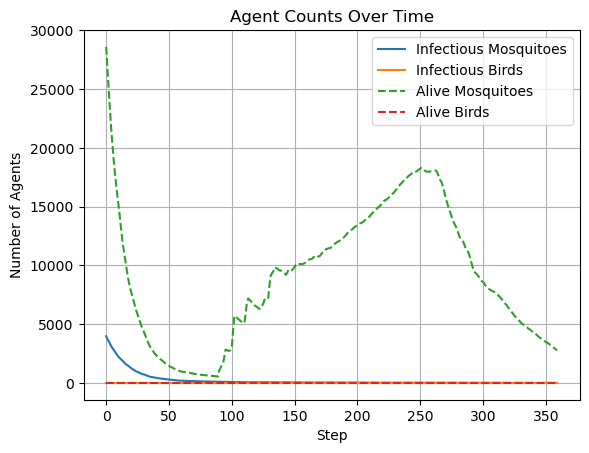

In [11]:
# Define GISDataHandler class
class GISDataHandler:
    def __init__(self, width, height, days, startDOY, mock=False):
        self.data_Temp_all = []
        self.data_Precipitation_all = []
        self.days = days
        self.startDOY = startDOY
        columns = ['LAT', 'LON', 'YEAR', 'DOY', 'Temp', 'Humidity', 'Precipitation']
        file_path = 'combined_data.csv'
        self.climate_data = pd.read_csv(file_path, usecols=range(len(columns)), names=columns, skiprows=1)
        self.get_all_climate_data()
        return
    
    def resize_Dataframe(self, df):
        df = df.reset_index(drop=True)
        df.columns = range(df.shape[1])
        data = df.to_numpy()
        df = scipy.ndimage.zoom(data, (392 / data.shape[0], 920 / data.shape[1]), order=1)
        df = pd.DataFrame(df)
        return df

    def daily_Climate(self, DOY):
        data_Temp = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Temp', aggfunc='mean')
        data_Humidity = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Humidity', aggfunc='mean')
        data_Precipitation = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Precipitation', aggfunc='mean')
        return (data_Temp, data_Humidity, data_Precipitation)
    
    def get_all_climate_data(self):
        for i in range(self.days):
            (data_Temp, data_Humidity, data_Precipitation) = self.daily_Climate(self.startDOY + i)
            data_Temp = self.resize_Dataframe(data_Temp)
            data_Humidity = self.resize_Dataframe(data_Humidity)
            self.data_Temp_all.append(data_Temp)
            self.data_Precipitation_all.append(data_Humidity)
        print(len(self.data_Temp_all))
        return
    
    def get_environmental_data(self, x, y, day):
        return self.data_Temp_all[day].iloc[y-1, x-1], self.data_Precipitation_all[day].iloc[y-1, x-1]
    

# Define Mosquito agent
class Mosquito(Agent):
    def __init__(self, unique_id, model, state="egg", parent_state=None):
        super().__init__(unique_id, model)
        self.state = state
        self.parent_state = parent_state

    def step(self):
        day = self.model.schedule.steps
        x, y = self.pos
        T, P = self.model.gis_data.get_environmental_data(x, y, day)

        # Diapause conditions
        diapause_temp_threshold = 10  # Temperature below which diapause can occur
        diapause_steps_start = 1  # Start of diapause period (e.g., step 300)
        diapause_steps_end = 60  # End of diapause period (e.g., step 360)

        # Exit diapause conditions
        wake_temp_threshold = 15  # Temperature above which mosquitoes can exit diapause
        wake_steps_start = 90  # Start of period where mosquitoes can exit diapause (e.g., spring)
        wake_steps_end = 250  # End of period where mosquitoes can exit diapause

        # Egg state: develop into larvae or die based on temperature and death rate
        if self.state == "egg":
            if random.random() < self.model.parameters.egg_to_larvae_rate(T, P):
                self.state = "susceptible"
            elif random.random() < self.model.parameters.mosquito_death_rate(T, P):
                self.state = "dead"

        # Susceptible state: move, enter diapause or die
        elif self.state == "susceptible":
            self.move()

            # Diapause conditions: if in the diapause step range and temperature is below the threshold
            if diapause_steps_start <= self.model.schedule.steps <= diapause_steps_end and T < diapause_temp_threshold:
                if random.random() < self.model.parameters.mosquito_death_rate(T, P):  # Probability of entering diapause (adjustable)
                    self.state = "diapause"
                else:
                    self.state = "dead" if random.random() < self.model.parameters.mosquito_death_rate(T, P) else self.state

            elif random.random() < self.model.parameters.mosquito_death_rate(T, P):
                self.state = "dead"
            elif self.model.check_infection(self):
                self.state = "infectious"
            self.give_birth(T, P)

        # Infectious state: move, enter diapause or die
        elif self.state == "infectious":
            self.move()

            if diapause_steps_start <= self.model.schedule.steps <= diapause_steps_end and T < diapause_temp_threshold:
                if random.random() < self.model.parameters.mosquito_death_rate(T, P):  # Probability of entering diapause
                    self.state = "diapause"
                else:
                    self.state = "dead" if random.random() < self.model.parameters.mosquito_death_rate(T, P) else self.state

            elif random.random() < self.model.parameters.mosquito_death_rate(T, P):
                self.state = "dead"
            self.give_birth(T, P)

        # Diapause state: check for conditions to wake from diapause
        elif self.state == "diapause":
            if wake_steps_start <= self.model.schedule.steps <= wake_steps_end and T > wake_temp_threshold:
                self.state = "susceptible"  # Exit diapause and become susceptible

        # Dead state: remove dead agents from grid and schedule
        elif self.state == "dead":
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    def move(self):
        attempts = 10  # Maximum number of attempts to find a suitable move
        for _ in range(attempts):
            # Get possible neighboring cells
            possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True, radius=self.random.randint(0, 1))
            
            # Randomly choose a new position
            new_position = random.choice(possible_steps)
            new_x, new_y = new_position

            # Ensure new position is within grid bounds and has suitability > 0
            if 0 <= new_x < self.model.grid.width and 0 <= new_y < self.model.grid.height:
                # Ensure new position is within suitability data bounds
                if 0 <= new_y < self.model.suitability_data.shape[0] and 0 <= new_x < self.model.suitability_data.shape[1]:
                    # Check if the suitability of the new position is greater than 0
                    if self.model.suitability_data.iloc[new_y, new_x] > 0:
                        # If the new position has a positive suitability value, move to it
                        self.model.grid.move_agent(self, new_position)
                        return  # Stop after finding a valid position

        # If no suitable location is found after several attempts, stay in place
        return


    def give_birth(self, T, P):
        # Check the number of agents in the neighborhood
        neighborhood_size = 10
        neighborhood = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True, radius=neighborhood_size)
        num_neighbors = len(neighborhood)

        # Calculate birth rate reduction based on density
        max_neighbors = 150  # Assuming a Moore neighborhood, max 8 neighbors
        density_factor = max(0, 1 - (num_neighbors / max_neighbors))  # Reduces birth rate with more neighbors

        # Adjust the birth probability based on environmental factors and density
        birth_probability = self.model.parameters.mosquito_birth_rate(T, P) * density_factor

        if random.random() < birth_probability:
        # if num_neighbors < 30 and random.random() < self.model.parameters.mosquito_birth_rate(T, P):
            x, y = self.pos
            new_mosquito = Mosquito(self.model.next_id(), self.model, state="egg", parent_state=self.state)
            self.model.schedule.add(new_mosquito)
            self.model.grid.place_agent(new_mosquito, (x, y))

# Define Bird agent
class Bird(Agent):
    def __init__(self, unique_id, model, state="susceptible"):
        super().__init__(unique_id, model)
        self.state = state

    def step(self):
        day = self.model.schedule.steps
        x, y = self.pos
        T, P = self.model.gis_data.get_environmental_data(x, y, day)

        if self.state == "susceptible":
            self.move()
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"
            elif self.model.check_infection(self):
                self.state = "infectious"
            self.give_birth(T, P)
        elif self.state == "infectious":
            self.move()
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"
            elif random.random() < self.model.parameters.recovery_rate:
                self.state = "susceptible"
            self.give_birth(T, P)
        elif self.state == "recovered":
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"
            self.give_birth(T, P)
        elif self.state == "dead":
            # remove dead agents from grid and schedule
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    def move(self):
        day = self.model.schedule.steps
        x, y = self.pos
        T, P = self.model.gis_data.get_environmental_data(x, y, day)

        optimal_temp = 20
        temp_std_dev = 10  # Standard deviation for temperature influence
        temp_factor = math.exp(-((T - optimal_temp) ** 2) / (2 * temp_std_dev ** 2))

        max_distance = 3
        movement_distance = temp_factor * max_distance

        # Add randomness to movement distance
        movement_distance = np.random.normal(loc=movement_distance, scale=1)
        movement_distance = max(0, min(movement_distance, max_distance))  # Ensure within bounds

        if movement_distance < 1:
            return  # Bird stays in place

        # Try to move in a suitable area
        attempts = 10  # Maximum number of attempts to find a suitable move
        for _ in range(attempts):
            # Choose random direction
            angle = random.uniform(0, 2 * math.pi)
            dx = int(round(movement_distance * math.cos(angle)))
            dy = int(round(movement_distance * math.sin(angle)))

            new_x = x + dx
            new_y = y + dy

            # Ensure new position is within grid bounds
            if 0 <= new_x < self.model.grid.width and 0 <= new_y < self.model.grid.height:
                # Ensure new position is within suitability data bounds
                if 0 <= new_y < self.model.suitability_data.shape[0] and 0 <= new_x < self.model.suitability_data.shape[1]:
                    # Check if the suitability of the new position is greater than 0
                    if self.model.suitability_data.iloc[new_y, new_x] > 0:
                        new_position = (new_x, new_y)
                        self.model.grid.move_agent(self, new_position)
                        return  # Stop after finding a valid position

        # If no suitable location is found after several attempts, stay in place
        return

    def give_birth(self, T, P):
        # Check the number of agents in the neighborhood
        neighborhood_size = 5
        neighborhood = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True, radius=neighborhood_size)
        num_neighbors = len(neighborhood)

        # Calculate birth rate reduction based on density
        # max_neighbors = 48  # Assuming a Moore neighborhood, max 8 neighbors
        max_neighbors = 150
        density_factor = max(0, 1 - (num_neighbors / max_neighbors))  # Reduces birth rate with more neighbors

        # Adjust the birth probability based on environmental factors and density
        birth_probability = self.model.parameters.mosquito_birth_rate(T, P) * density_factor

        # if random.random() < birth_probability:
        if num_neighbors < 100 and random.random() < self.model.parameters.bird_birth_rate(T, P):
            x, y = self.pos
            new_bird = Bird(self.model.next_id(), self.model, state="susceptible")
            self.model.schedule.add(new_bird)
            self.model.grid.place_agent(new_bird, (x, y))

# Define WNVModel
class WNVModel(Model):
    def __init__(self, parameters, mock=True):
        super().__init__()
        self.parameters = parameters
        self.grid = MultiGrid(self.parameters.grid_width, self.parameters.grid_height, torus=False)
        self.schedule = RandomActivation(self)
        self.gis_data = GISDataHandler(self.parameters.grid_width, self.parameters.grid_height, self.parameters.simulation_steps, self.parameters.startDOY, mock=mock)
        self.suitability_data = pd.read_parquet('suitability_data.parquet')
        self.initialize_agents()
        self.infectious_counts = {'mosquitoes': [], 'birds': []}
        self.alive_counts = {'mosquitoes': [], 'birds': []}
        self.results_file = open('simulation_results.csv', 'w', newline='')
        self.csv_writer = csv.writer(self.results_file)
        self.csv_writer.writerow(['step', 'agent_id', 'agent_type', 'x', 'y', 'state'])

    def initialize_agents(self):
        # Initialize Mosquito (using the distribution data)
        print('Mosquito:')
        initial_infectious_mosquitoes = int(self.parameters.initial_mosquito_count * self.parameters.initial_infectious_fraction)
        culex_distribution = pd.read_parquet('culex_distribution.parquet')
        mosquito_id = 0  # Starting ID for mosquitoes
        for x in range(culex_distribution.shape[0]):  # Rows
            print(x, ',', end=' ')
            for y in range(culex_distribution.shape[1]):  # Columns
                # print(x, ' ', y)
                num_groups = culex_distribution.iloc[x, y]  # Number of mosquito groups in this cell
                for _ in range(int(num_groups)):  # Each group represents 100 mosquitoes
                    state = "infectious" if mosquito_id < initial_infectious_mosquitoes else "susceptible"
                    mosquito = Mosquito(mosquito_id, self, state)
                    self.schedule.add(mosquito)
                    self.grid.place_agent(mosquito, (y, x))
                    mosquito_id += 1

        print('')

        # Initialize Birds (using the distribution data)
        print('Birds:')
        # initial_infectious_birds = int(self.parameters.initial_bird_count * self.parameters.initial_infectious_fraction)
        # bird_distribution = pd.read_parquet('amerob_2022-09-06.parquet')
        # bird_id = 0  # Starting ID for birds
        # for x in range(bird_distribution.shape[0]):  # Rows
        #     print(x, ',', end=' ')
        #     for y in range(bird_distribution.shape[1]): # Columns
        #         num_groups = bird_distribution.iloc[x, y]
        #         for _ in range(int(num_groups)):
        #             state = "infectious" if bird_id < initial_infectious_birds else "susceptible"
        #             bird = Bird(bird_id, self, state)
        #             self.schedule.add(bird)
        #             self.grid.place_agent(bird, (y, x))
        #             bird_id += 1

    def step(self):
        self.schedule.step()

        # if (self.schedule.steps % 20 == 0 and self.schedule.steps >= 90) or (self.schedule.steps < 95 and self.schedule.steps > 90):
        #     self.repopulate_empty_cells(self.schedule.steps)

        # self.save_results()
        self.collect_data()
        
    # New repopulation method with susitability and neighborhood checks
    def repopulate_empty_cells(self, step):
        neighborhood_size=10
        threshold=0.3
        """Check for empty regions and add agents if the area is suitable."""
        if (step > 100 and step < 105) or (step > 200 and step < 205):
            for x in range(150,250):
                for y in range(50,130):
                    if self.suitability_data.iloc[x, y] >= 0.8:
                        num_new_agents = random.randint(1, 10)  # Number of agents to add
                        for _ in range(num_new_agents):
                            new_mosquito = Mosquito(self.next_id(), self, state="egg")
                            self.schedule.add(new_mosquito)
                            self.grid.place_agent(new_mosquito, (y, x))

        for x in range(self.suitability_data.shape[0]):
            for y in range(self.suitability_data.shape[1]):
                # Check if the area is suitable based on suitability data
                if self.suitability_data.iloc[x, y] >= threshold:  # Only repopulate areas with suitable conditions
                    # Define the neighborhood area to check for agents (5x5 or 10x10)
                    neighborhood = self.grid.get_neighborhood((y, x), moore=True, radius=neighborhood_size, include_center=True)
                    agents_in_neighborhood = [agent for pos in neighborhood for agent in self.grid.get_cell_list_contents(pos)]

                    # If no agents are present in the neighborhood, repopulate the area
                    if len(agents_in_neighborhood) < 5:
                        # Add some new agents randomly in the neighborhood
                        num_new_agents = random.randint(1, 10)  # Number of agents to add
                        for _ in range(num_new_agents):
                            # # Create new mosquito agent
                            # new_mosquito = Mosquito(self.next_id(), self, state="egg")
                            # self.schedule.add(new_mosquito)
                            # self.grid.place_agent(new_mosquito, (y, x))
                            # Create new bird agent
                            new_bird = Bird(self.next_id(), self, state="susceptible")
                            self.schedule.add(new_bird)
                            self.grid.place_agent(new_bird, (y, x))


    def save_results(self):
        for agent in self.schedule.agents:
            self.csv_writer.writerow([self.schedule.steps, agent.unique_id, type(agent).__name__, agent.pos[0], agent.pos[1], agent.state])

    def collect_data(self):
        mosquito_infectious_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Mosquito) and agent.state == "infectious")
        bird_infectious_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Bird) and agent.state == "infectious")
        mosquito_alive_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead" and agent.state != "diapause")
        bird_alive_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Bird) and agent.state != "dead")

        self.infectious_counts['mosquitoes'].append(mosquito_infectious_count)
        self.infectious_counts['birds'].append(bird_infectious_count)
        self.alive_counts['mosquitoes'].append(mosquito_alive_count)
        self.alive_counts['birds'].append(bird_alive_count)

    def __del__(self):
        self.results_file.close()

    def check_infection(self, agent):
        x, y = agent.pos
        day = self.schedule.steps
        T, P = self.gis_data.get_environmental_data(x, y, day)
        neighbors = self.grid.get_neighbors(agent.pos, moore=True, include_center=False)

        if isinstance(agent, Mosquito):
            for neighbor in neighbors:
                if isinstance(neighbor, Bird) and neighbor.state == "infectious":
                    return random.random() < self.parameters.infection_probability(T)
        elif isinstance(agent, Bird):
            for neighbor in neighbors:
                if isinstance(neighbor, Mosquito) and neighbor.state == "infectious":
                    return random.random() < self.parameters.infection_probability(T)
        return False

# Visualization function
def Visualize_simulation(model, num_steps, map_image_path='MapV3.png', output_folder='simulation_images'):
    img = mpimg.imread(map_image_path)

    num = 1
    print('')
    for step in range(num_steps):
        print('step = ', num)
        model.step()
        num = num + 1

        fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
        ax.imshow(img, extent=[0, model.grid.width, 0, model.grid.height])
        x_mosquitoes = [agent.pos[0] for agent in model.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead" and agent.state != "diapause"]
        y_mosquitoes = [agent.pos[1] for agent in model.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead" and agent.state != "diapause"]
        x_birds = [agent.pos[0] for agent in model.schedule.agents if isinstance(agent, Bird) and agent.state != "dead"]
        y_birds = [agent.pos[1] for agent in model.schedule.agents if isinstance(agent, Bird) and agent.state != "dead"]
        ax.scatter(x_mosquitoes, y_mosquitoes, c='red', label='Mosquitoes', s=1, alpha=0.6)
        ax.scatter(x_birds, y_birds, c='blue', label='Birds', s=1, alpha=0.5)
        ax.set_xlim(0, model.grid.width)
        ax.set_ylim(0, model.grid.height)
        ax.set_title(f'Step {step + 1}')
        ax.legend()
        plt.savefig(os.path.join(output_folder, f'step_{step + 1:03d}.png'))
        plt.close(fig)

# Plot infectious counts
def plot_infectious_counts(model):
    steps = range(len(model.infectious_counts['mosquitoes']))
    plt.figure()
    plt.plot(steps, model.infectious_counts['mosquitoes'], label='Infectious Mosquitoes')
    plt.plot(steps, model.infectious_counts['birds'], label='Infectious Birds')
    plt.plot(steps, model.alive_counts['mosquitoes'], label='Alive Mosquitoes', linestyle='--')
    plt.plot(steps, model.alive_counts['birds'], label='Alive Birds', linestyle='--')
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.title('Agent Counts Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig('agent_counts.png')
    plt.show()

# Running the model
if __name__ == "__main__":
    parameters = WNVParameters()
    model = WNVModel(parameters)
    Visualize_simulation(model, num_steps=parameters.simulation_steps)
    plot_infectious_counts(model)


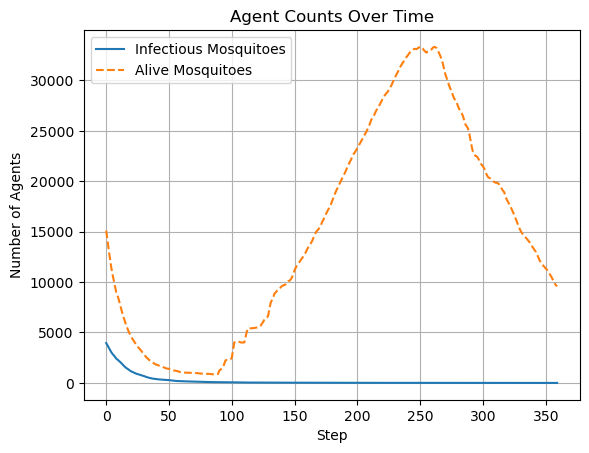

In [15]:
def plot_infectious_counts_1(model):
    steps = range(len(model.infectious_counts['mosquitoes']))
    plt.figure()
    plt.plot(steps, model.infectious_counts['mosquitoes'], label='Infectious Mosquitoes')
    # plt.plot(steps, model.infectious_counts['birds'], label='Infectious Birds')
    plt.plot(steps, model.alive_counts['mosquitoes'], label='Alive Mosquitoes', linestyle='--')
    # plt.plot(steps, model.alive_counts['birds'], label='Alive Birds', linestyle='--')
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.title('Agent Counts Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig('agent_counts.png')
    plt.show()

plot_infectious_counts_1(model)